### Data Preparation

#### Merge customer, product, and transaction data to create a unified dataset for analysis.

In [1]:
import pandas as pd

# Load datasets
customers = pd.read_csv("../datasets/Customers.csv")
products = pd.read_csv("../datasets/Products.csv")
transactions = pd.read_csv("../datasets/Transactions.csv")

In [2]:
# Merge datasets
merged_df = transactions.merge(customers, on="CustomerID", how="left")
merged_df = merged_df.merge(products, on="ProductID", how="left")
merged_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [3]:
# Feature Engineering: Create features like total spending, product preferences, and transaction frequency
customer_features = (
    merged_df.groupby("CustomerID")
    .agg(
        total_spending=("TotalValue", "sum"),
        transaction_count=("TransactionID", "count"),
        avg_transaction_value=("TotalValue", "mean"),
    )
    .reset_index()
)
customer_features.head()

,CustomerID,total_spending,transaction_count,avg_transaction_value
0,C0001,3354.52,5,670.904
1,C0002,1862.74,4,465.685
2,C0003,2725.38,4,681.345
3,C0004,5354.88,8,669.360
4,C0005,2034.24,3,678.080


In [4]:
# Add product preferences: Count of products purchased by category
product_preferences = (
    merged_df.groupby(["CustomerID", "Category"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
product_preferences.head()

Category,CustomerID,Books,Clothing,Electronics,Home Decor
0,C0001,1,0,3,1
1,C0002,0,2,0,2
2,C0003,0,1,1,2
3,C0004,3,0,2,3
4,C0005,0,0,2,1


In [5]:
# Merge all features into a single dataframe
customer_features = customer_features.merge(product_preferences, on="CustomerID", how="left")
customer_features.head()


,CustomerID,total_spending,transaction_count,avg_transaction_value,Books,Clothing,Electronics,Home Decor
0,C0001,3354.52,5,670.904,1,0,3,1
1,C0002,1862.74,4,465.685,0,2,0,2
2,C0003,2725.38,4,681.345,0,1,1,2
3,C0004,5354.88,8,669.360,3,0,2,3
4,C0005,2034.24,3,678.080,0,0,2,1


### Similarity Calculation

#### Use cosine similarity to calculate similarity scores between customers based on their profiles and transaction history.

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Prepare feature matrix for similarity calculation
feature_matrix = customer_features.drop(columns=["CustomerID"]).fillna(0)
similarity_matrix = cosine_similarity(feature_matrix)

In [7]:
feature_matrix.head()

,total_spending,transaction_count,avg_transaction_value,Books,Clothing,Electronics,Home Decor
0,3354.52,5,670.904,1,0,3,1
1,1862.74,4,465.685,0,2,0,2
2,2725.38,4,681.345,0,1,1,2
3,5354.88,8,669.360,3,0,2,3
4,2034.24,3,678.080,0,0,2,1


In [8]:
# Create a DataFrame for easy access
similarity_df = pd.DataFrame(
    similarity_matrix, 
    index=customer_features["CustomerID"], 
    columns=customer_features["CustomerID"]
)
similarity_df.head()

CustomerID,C0001,C0002,C0003,C0004,C0005,C0006,C0007,C0008,C0009,C0010,...,C0191,C0192,C0193,C0194,C0195,C0196,C0197,C0198,C0199,C0200
CustomerID,,,,,,,,,,,,,,,,,,,,,
C0001,1.000000,0.998867,0.998868,0.997334,0.992278,0.998868,0.992278,0.995228,0.992274,0.998866,...,1.000000,0.998868,0.998867,0.998460,0.999480,0.998867,0.992278,0.964763,0.998868,1.000000
C0002,0.998867,1.000000,0.999999,0.992733,0.997053,0.999999,0.997053,0.989461,0.997052,0.999999,...,0.998866,0.999999,0.999998,0.994691,0.996815,0.999999,0.997053,0.976186,0.999999,0.998867
C0003,0.998868,0.999999,1.000000,0.992734,0.997054,1.000000,0.997054,0.989461,0.997051,0.999998,...,0.998867,0.999999,0.999999,0.994692,0.996815,1.000000,0.997054,0.976186,1.000000,0.998868
C0004,0.997334,0.992733,0.992734,1.000000,0.980580,0.992733,0.980580,0.999695,0.980577,0.992732,...,0.997333,0.992733,0.992733,0.999846,0.999168,0.992733,0.980580,0.942990,0.992733,0.997333
C0005,0.992278,0.997053,0.997054,0.980580,1.000000,0.997054,1.000000,0.975440,0.999996,0.997052,...,0.992277,0.997054,0.997053,0.983870,0.987763,0.997054,1.000000,0.989949,0.997054,0.992277


### Generate Recommendations

#### For each customer in the range C0001–C0020, find the top 3 similar customers.

In [9]:
def get_top_3_similar(customers_range, similarity_df):
    lookalikes = {}
    for customer_id in customers_range:
        # Get similarity scores for the customer
        if customer_id in similarity_df.index:
            scores = similarity_df[customer_id].sort_values(ascending=False)
            # Exclude self and get top 3
            top_3 = scores.iloc[1:4]
            lookalikes[customer_id] = list(zip(top_3.index, top_3.values))
    return lookalikes

# Define the range of CustomerIDs (C0001–C0020)
customers_range = [f"C{str(i).zfill(4)}" for i in range(1, 21)]

# Get top 3 similar customers for each
lookalike_map = get_top_3_similar(customers_range, similarity_df)

# Convert to a DataFrame and save as Lookalike.csv
lookalike_df = pd.DataFrame.from_dict(
    {
        cust_id: [{"cust_id": similar[0], "score": similar[1]} for similar in similar_list]
        for cust_id, similar_list in lookalike_map.items()
    },
    orient="index"
).reset_index().rename(columns={"index": "CustomerID"})

lookalike_df.to_csv("Medha_Agarwal_Lookalike.csv", index=False)


### Ensuring Model Accuracy and Logic

#### a. Feature Engineering Validation
1. Checking correlations between features and customer behaviors.
2. Visualizing distributions (e.g., histograms, scatter plots) to ensure they make sense.

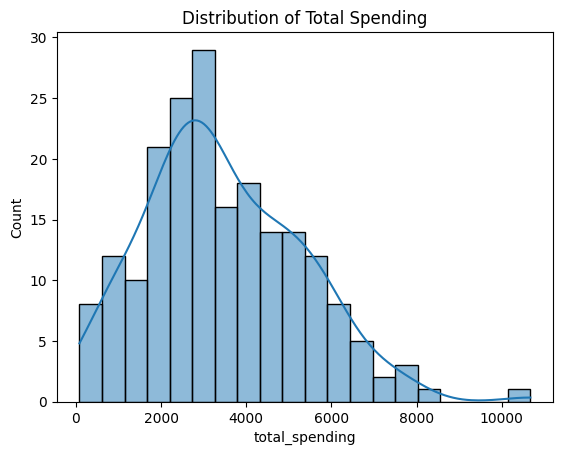

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Visualize distribution of total spending
sns.histplot(customer_features["total_spending"], bins=20, kde=True)
plt.title("Distribution of Total Spending")
plt.show()


#### b. Similarity Matrix Validation
1. No values exceed 1 (cosine similarity ranges between 0 and 1).
2. Self-similarity (diagonal values) is always 1.

In [11]:
# Check self-similarity
self_similarity = np.allclose(np.diag(similarity_matrix), 1.0)
print("Self-similarity valid:", self_similarity)

# Check that no similarity score exceeds 1
max_score = np.max(similarity_matrix)
print("Max similarity score:", max_score)


Self-similarity valid: True
Max similarity score: 1.0000000000000004
